In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
BATCH_SIZE = 100     
N_EPOCHS = 10       
INPUT_DIM = 28 * 28 
HIDDEN_DIM = 500    
LATENT_DIM = 20
LOG_INTERVAL = 50
lr = 1e-3

In [4]:
train_loader, test_loader = mnist(batch_size=BATCH_SIZE)

In [5]:
 class Encoder(nn.Module): # Энкодер
        
        def __init__(self, input_dim, hidden_dim, z_dim):
            '''
            Args:
                input_dim: Размер входящих данных
                hidden_dim: размер скрытого слоя
                z_dim: Размер латентного слоя
            '''
            super().__init__()

            self.linear = nn.Linear(input_dim, hidden_dim)
            self.mu = nn.Linear(hidden_dim, z_dim)
            self.var = nn.Linear(hidden_dim, z_dim)

        def forward(self, x):
            # x размерномти [batch_size, input_dim]

            hidden = F.relu(self.linear(x))
            # hidden размерномти  [batch_size, hidden_dim]
            mu = self.mu(hidden)
            # z_mu размерномти [batch_size, latent_dim]
            logvar = self.var(hidden)
            # logvar размерномти [batch_size, latent_dim]

            return mu, logvar

In [6]:
class Decoder(nn.Module): #Декодер
    
        def __init__(self, z_dim, hidden_dim, output_dim):
            '''
            Args:
                z_dim: Размнерность латентног ослоя
                hidden_dim: Размерность скрытого слоя.
                output_dim: размерность выходных данных 28*28
            '''
            super().__init__()

            self.linear = nn.Linear(z_dim, hidden_dim)
            self.out = nn.Linear(hidden_dim, output_dim)

        def forward(self, x):
            # x размерность [batch_size, latent_dim]

            hidden = F.relu(self.linear(x))
            # hidden размерность [batch_size, hidden_dim]

            predicted = torch.sigmoid(self.out(hidden))
            # predicted размерность [batch_size, output_dim]

            return predicted

In [7]:
class VAE(nn.Module): #VAE
    
        def __init__(self, enc, dec):
            super().__init__()

            self.enc = enc
            self.dec = dec

        def forward(self, x):
            # Кодирование
            mu, logvar = self.enc(x)

            # Семплирование из распределения латентного слоя z_mu, z_logvar
            # Репараметаризация 
            
            #Тензор стандартных отклонений 
            std = torch.exp(logvar / 2)
            
            # Генерируем тензор рандомного нормального распределение [0,1), размером как std
            eps = torch.randn_like(std)
            
            # Приводим к полученному распределению
            x_sample = eps.mul(std).add_(mu)

            # decode
            predicted = self.dec(x_sample)
            return predicted, mu, logvar

In [8]:
def loss_function(recon_x, x, mu, logvar) -> Variable:
    # Насколько хорошо восстановлена картинка относительно оригинала (обычная кросс-энтиропия)
    reconstruction_loss = F.binary_cross_entropy(recon_x, x.view(-1, 28*28))

    # KLD - дивергенция Кульбака-Лейблера -- кол-во разницы информации между двумя распределения.
    # В нашем cлучае насколько обученное распредленеи отклоняется от нормального. 
    # не дает сужать распределения - что позвляет им пересекаться

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # - D_{KL} = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # note the negative D_{KL} in appendix B of the paper
    
    KLD_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Normalise by same number of elements as in reconstruction - не уверен что нужно ???
    KLD_loss /= BATCH_SIZE * 784

    # reconstruction_loss пытается делать восстанавливаемые изображения похожими на оригинал.
    # KLD_loss пытается приблизить распредление латентного слоя ближе к единичному нормальному распределению.
    return reconstruction_loss + KLD_loss

In [9]:
# Экодер
encoder = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM)

# Декодер
decoder = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM)

# VAE
model = VAE(encoder, decoder).to(device)

# Оптимизатор
optimizer = optim.Adam(model.parameters(), lr=lr)

In [10]:
def train(epoch):
    # Переключаем в режим тренировки
    model.train()
    train_loss = 0
    
    # in the case of MNIST, len(train_loader.dataset) is 60000
    # each `data` is of BATCH_SIZE samples and has shape [128, 1, 28, 28]
    for batch_idx, (x, _) in enumerate(train_loader):
        
        # reshape the data into [batch_size, 784]
        x = x.view(-1, 28 * 28)
        x = x.to(device)

        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        x_recon, mu, logvar = model(x)

        # total loss
        loss = loss_function(x_recon, x, mu, logvar)

        # backward pass
        loss.backward()
        train_loss += loss.item()

        # update the weights
        optimizer.step()
        
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(x)))

    print('*Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))


In [11]:
def test(epoch):
    # переключение в режим вычисления
    model.eval()
    
    test_loss = 0

    with torch.no_grad():
        for i, (x, _) in enumerate(test_loader):
            
            # Приведение в линейный вид
            x = x.view(-1, 28 * 28)
            x = x.to(device)

            # Прогон Энкоддер - Декодер
            x_sample, mu, logvar = model(x)
        
            test_loss += loss_function(x_sample, x, mu, logvar).item()
            
            if i == 0:
                to_plot = x_sample[:10].view(10, 1, 28, 28)
                plot_mnist(x[:10].view(10, 1, 28, 28), (1, 10))
                plot_mnist(to_plot, (1, 10))

        test_loss /= len(test_loader.dataset)
        print('*Test set loss of epoch {}: {:.4f}'.format(epoch, test_loss))
        
    return test_loss

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.007008
Train Epoch: 1 [5000/60000 (8%)]	Loss: -0.085281
Train Epoch: 1 [10000/60000 (17%)]	Loss: -0.132290
Train Epoch: 1 [15000/60000 (25%)]	Loss: -0.162343
Train Epoch: 1 [20000/60000 (33%)]	Loss: -0.180630
Train Epoch: 1 [25000/60000 (42%)]	Loss: -0.190141
Train Epoch: 1 [30000/60000 (50%)]	Loss: -0.192508
Train Epoch: 1 [35000/60000 (58%)]	Loss: -0.197129
Train Epoch: 1 [40000/60000 (67%)]	Loss: -0.202434
Train Epoch: 1 [45000/60000 (75%)]	Loss: -0.204428
Train Epoch: 1 [50000/60000 (83%)]	Loss: -0.209286
Train Epoch: 1 [55000/60000 (92%)]	Loss: -0.215443
====> Epoch: 1 Average loss: -0.1748


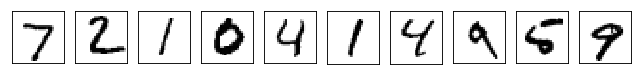

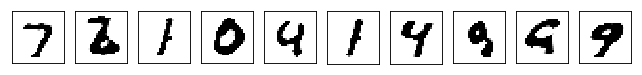

====> Test set loss of epoch 1: -0.2142
Train Epoch: 2 [0/60000 (0%)]	Loss: -0.209773
Train Epoch: 2 [5000/60000 (8%)]	Loss: -0.215054
Train Epoch: 2 [10000/60000 (17%)]	Loss: -0.212032
Train Epoch: 2 [15000/60000 (25%)]	Loss: -0.214722
Train Epoch: 2 [20000/60000 (33%)]	Loss: -0.213576
Train Epoch: 2 [25000/60000 (42%)]	Loss: -0.217695
Train Epoch: 2 [30000/60000 (50%)]	Loss: -0.214881
Train Epoch: 2 [35000/60000 (58%)]	Loss: -0.217296
Train Epoch: 2 [40000/60000 (67%)]	Loss: -0.215469
Train Epoch: 2 [45000/60000 (75%)]	Loss: -0.211941
Train Epoch: 2 [50000/60000 (83%)]	Loss: -0.211923
Train Epoch: 2 [55000/60000 (92%)]	Loss: -0.214596
====> Epoch: 2 Average loss: -0.2119


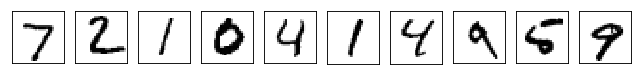

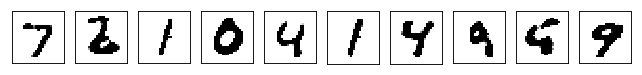

====> Test set loss of epoch 2: -0.2085
Train Epoch: 3 [0/60000 (0%)]	Loss: -0.213030
Train Epoch: 3 [5000/60000 (8%)]	Loss: -0.200075
Train Epoch: 3 [10000/60000 (17%)]	Loss: -0.215429
Train Epoch: 3 [15000/60000 (25%)]	Loss: -0.207897
Train Epoch: 3 [20000/60000 (33%)]	Loss: -0.209796
Train Epoch: 3 [25000/60000 (42%)]	Loss: -0.205676
Train Epoch: 3 [30000/60000 (50%)]	Loss: -0.209004
Train Epoch: 3 [35000/60000 (58%)]	Loss: -0.203764
Train Epoch: 3 [40000/60000 (67%)]	Loss: -0.210698
Train Epoch: 3 [45000/60000 (75%)]	Loss: -0.214607
Train Epoch: 3 [50000/60000 (83%)]	Loss: -0.213112
Train Epoch: 3 [55000/60000 (92%)]	Loss: -0.206741
====> Epoch: 3 Average loss: -0.2083


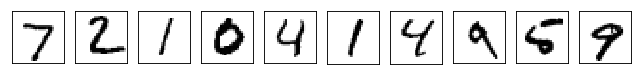

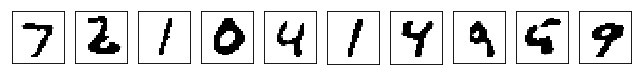

====> Test set loss of epoch 3: -0.2123
Train Epoch: 4 [0/60000 (0%)]	Loss: -0.211768
Train Epoch: 4 [5000/60000 (8%)]	Loss: -0.211464
Train Epoch: 4 [10000/60000 (17%)]	Loss: -0.204516
Train Epoch: 4 [15000/60000 (25%)]	Loss: -0.214579
Train Epoch: 4 [20000/60000 (33%)]	Loss: -0.202326
Train Epoch: 4 [25000/60000 (42%)]	Loss: -0.202956
Train Epoch: 4 [30000/60000 (50%)]	Loss: -0.197732
Train Epoch: 4 [35000/60000 (58%)]	Loss: -0.209842
Train Epoch: 4 [40000/60000 (67%)]	Loss: -0.205594
Train Epoch: 4 [45000/60000 (75%)]	Loss: -0.213827
Train Epoch: 4 [50000/60000 (83%)]	Loss: -0.209025
Train Epoch: 4 [55000/60000 (92%)]	Loss: -0.198583
====> Epoch: 4 Average loss: -0.2071


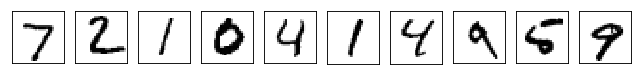

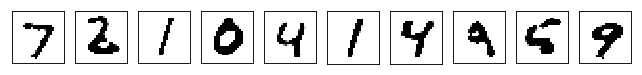

====> Test set loss of epoch 4: -0.2052
Train Epoch: 5 [0/60000 (0%)]	Loss: -0.204870
Train Epoch: 5 [5000/60000 (8%)]	Loss: -0.205788
Train Epoch: 5 [10000/60000 (17%)]	Loss: -0.208213
Train Epoch: 5 [15000/60000 (25%)]	Loss: -0.205108
Train Epoch: 5 [20000/60000 (33%)]	Loss: -0.210715
Train Epoch: 5 [25000/60000 (42%)]	Loss: -0.198113
Train Epoch: 5 [30000/60000 (50%)]	Loss: -0.213140
Train Epoch: 5 [35000/60000 (58%)]	Loss: -0.205315
Train Epoch: 5 [40000/60000 (67%)]	Loss: -0.212438
Train Epoch: 5 [45000/60000 (75%)]	Loss: -0.213492
Train Epoch: 5 [50000/60000 (83%)]	Loss: -0.209331
Train Epoch: 5 [55000/60000 (92%)]	Loss: -0.208006
====> Epoch: 5 Average loss: -0.2076


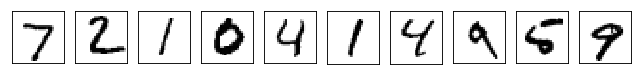

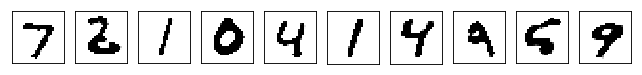

====> Test set loss of epoch 5: -0.2098
Train Epoch: 6 [0/60000 (0%)]	Loss: -0.217117
Train Epoch: 6 [5000/60000 (8%)]	Loss: -0.209159
Train Epoch: 6 [10000/60000 (17%)]	Loss: -0.203157
Train Epoch: 6 [15000/60000 (25%)]	Loss: -0.201905
Train Epoch: 6 [20000/60000 (33%)]	Loss: -0.201106
Train Epoch: 6 [25000/60000 (42%)]	Loss: -0.211046
Train Epoch: 6 [30000/60000 (50%)]	Loss: -0.210436
Train Epoch: 6 [35000/60000 (58%)]	Loss: -0.211477
Train Epoch: 6 [40000/60000 (67%)]	Loss: -0.211189
Train Epoch: 6 [45000/60000 (75%)]	Loss: -0.214950
Train Epoch: 6 [50000/60000 (83%)]	Loss: -0.208380
Train Epoch: 6 [55000/60000 (92%)]	Loss: -0.214208
====> Epoch: 6 Average loss: -0.2081


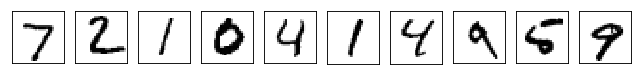

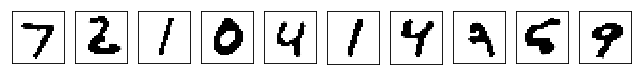

====> Test set loss of epoch 6: -0.2099
Train Epoch: 7 [0/60000 (0%)]	Loss: -0.208481
Train Epoch: 7 [5000/60000 (8%)]	Loss: -0.204873
Train Epoch: 7 [10000/60000 (17%)]	Loss: -0.208679
Train Epoch: 7 [15000/60000 (25%)]	Loss: -0.210454
Train Epoch: 7 [20000/60000 (33%)]	Loss: -0.212100
Train Epoch: 7 [25000/60000 (42%)]	Loss: -0.206205
Train Epoch: 7 [30000/60000 (50%)]	Loss: -0.211644
Train Epoch: 7 [35000/60000 (58%)]	Loss: -0.208994
Train Epoch: 7 [40000/60000 (67%)]	Loss: -0.209097
Train Epoch: 7 [45000/60000 (75%)]	Loss: -0.206952
Train Epoch: 7 [50000/60000 (83%)]	Loss: -0.205179
Train Epoch: 7 [55000/60000 (92%)]	Loss: -0.208070
====> Epoch: 7 Average loss: -0.2082


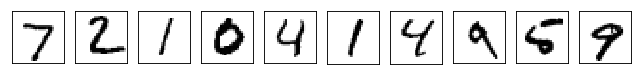

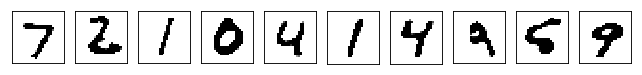

====> Test set loss of epoch 7: -0.2081
Train Epoch: 8 [0/60000 (0%)]	Loss: -0.200478
Train Epoch: 8 [5000/60000 (8%)]	Loss: -0.202944
Train Epoch: 8 [10000/60000 (17%)]	Loss: -0.210722
Train Epoch: 8 [15000/60000 (25%)]	Loss: -0.201956
Train Epoch: 8 [20000/60000 (33%)]	Loss: -0.213275
Train Epoch: 8 [25000/60000 (42%)]	Loss: -0.214890
Train Epoch: 8 [30000/60000 (50%)]	Loss: -0.212260
Train Epoch: 8 [35000/60000 (58%)]	Loss: -0.224042
Train Epoch: 8 [40000/60000 (67%)]	Loss: -0.218522
Train Epoch: 8 [45000/60000 (75%)]	Loss: -0.198972
Train Epoch: 8 [50000/60000 (83%)]	Loss: -0.209202
Train Epoch: 8 [55000/60000 (92%)]	Loss: -0.210603
====> Epoch: 8 Average loss: -0.2088


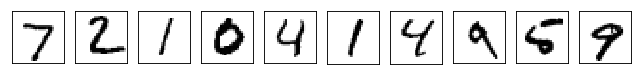

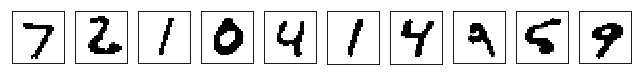

====> Test set loss of epoch 8: -0.2105
Train Epoch: 9 [0/60000 (0%)]	Loss: -0.203982
Train Epoch: 9 [5000/60000 (8%)]	Loss: -0.209367
Train Epoch: 9 [10000/60000 (17%)]	Loss: -0.210137
Train Epoch: 9 [15000/60000 (25%)]	Loss: -0.211302
Train Epoch: 9 [20000/60000 (33%)]	Loss: -0.210480
Train Epoch: 9 [25000/60000 (42%)]	Loss: -0.218777
Train Epoch: 9 [30000/60000 (50%)]	Loss: -0.214355
Train Epoch: 9 [35000/60000 (58%)]	Loss: -0.209266
Train Epoch: 9 [40000/60000 (67%)]	Loss: -0.217497
Train Epoch: 9 [45000/60000 (75%)]	Loss: -0.203736
Train Epoch: 9 [50000/60000 (83%)]	Loss: -0.205726
Train Epoch: 9 [55000/60000 (92%)]	Loss: -0.205466
====> Epoch: 9 Average loss: -0.2088


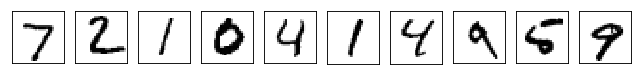

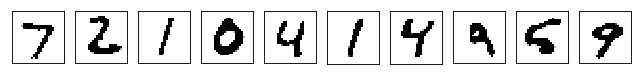

====> Test set loss of epoch 9: -0.2093
Train Epoch: 10 [0/60000 (0%)]	Loss: -0.216611
Train Epoch: 10 [5000/60000 (8%)]	Loss: -0.202549
Train Epoch: 10 [10000/60000 (17%)]	Loss: -0.213795
Train Epoch: 10 [15000/60000 (25%)]	Loss: -0.206934
Train Epoch: 10 [20000/60000 (33%)]	Loss: -0.202420
Train Epoch: 10 [25000/60000 (42%)]	Loss: -0.211117
Train Epoch: 10 [30000/60000 (50%)]	Loss: -0.207841
Train Epoch: 10 [35000/60000 (58%)]	Loss: -0.207293
Train Epoch: 10 [40000/60000 (67%)]	Loss: -0.210485
Train Epoch: 10 [45000/60000 (75%)]	Loss: -0.206532
Train Epoch: 10 [50000/60000 (83%)]	Loss: -0.213956
Train Epoch: 10 [55000/60000 (92%)]	Loss: -0.208958
====> Epoch: 10 Average loss: -0.2089


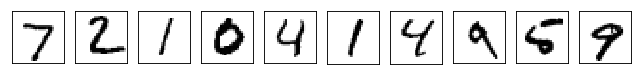

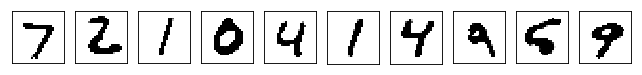

====> Test set loss of epoch 10: -0.2103


In [12]:
for epoch in range(1, N_EPOCHS + 1):
    train(epoch)
    test(epoch)

In [13]:
# Вопросы:
# Почему получаетя лосс отрицательный? 
# Как сделать чтобы он стабильно стремился к 0 или тут этого не надо?